In [1]:
import torch
import numpy as np
from pathlib import Path
from cartesian_polar.exp_autoencoder.agent import Autoencoder
import random
import matplotlib.pyplot as plt
import tqdm
from environment import DuplicatedCoordsEnv
import pandas as pd
import itertools
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import normalize, StandardScaler
import pickle

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
save_path = Path("save")
save_path.exists()

True

In [7]:
data_dir_ew = save_path / "7-30-A-10-EW-2"
data_dir_lr = save_path / "8-1-10-LR"
print(data_dir_ew.exists())
print(data_dir_lr.exists())

True
True


In [8]:
data_path_ew = data_dir_ew / "data.tar"
data_path_lr = data_dir_lr / "data.tar"
print(data_path_ew.exists())
print(data_path_lr.exists())

True
True


In [9]:
data_dict_ew = torch.load(data_path_ew, weights_only=False, map_location=DEVICE)
data_dict_lr = torch.load(data_path_lr, weights_only=False, map_location=DEVICE)
data_dict_ew.keys()
data_dict_lr.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

In [10]:
# ASSUMING EQUAL ARCHITECTURES
parameters = data_dict_ew['p']
n_observations = parameters.n_observations
n_actions = parameters.n_actions
n_units = parameters.n_hidden_units
bottleneck = parameters.bottleneck

In [11]:
env = data_dict_ew['env'] # assuming equal environments

## Helper Functions

In [12]:
"""
Function for converting angle degree to cardinal direction
"""
def degrees_to_cardinal(degree):
    # Normalize the degree to [0, 360)
    degree = degree % 360

    # Define the mapping
    directions = {
        0: 'N',
        90: 'E',
        180: 'S',
        270: 'W'
    }

    # Find the closest cardinal angle
    closest = min(directions.keys(), key=lambda x: abs(x - degree))
    return directions[closest]

In [13]:
def convert_state_sample_to_orig_sample(state_sample):
    orig_state_samples = []
    for state in state_sample:

        if state[0].item() == 1:
            odor_cue = 'No Odor'
        elif state[1].item() == 1:
            odor_cue = 'Odor A'
        else:
            odor_cue = 'Odor B'

        coords_orig = env.conv_north_cartesian2orig(state[3:7]).tolist()
        coords_orig.insert(0, odor_cue)
        
        head_deg = coords_orig[3]
        head_cardinal = degrees_to_cardinal(head_deg)
        coords_orig[3] = head_cardinal
        
        coords_orig.append(state[3].item()) # CNP x
        coords_orig.append(state[4].item()) # CNP y
        coords_orig.append(state[7].item()) # CSP x
        coords_orig.append(state[8].item()) # CSP y

        orig_state_samples.append(coords_orig)
    return orig_state_samples

In [14]:
def get_layer_activations(net, input_states, layer_index):
    activations_list = []

    def hook(module, input, output):
        activations_list.append(output.detach().cpu().numpy().squeeze())

    # Register hook
    handle = list(net.mlp.children())[layer_index].register_forward_hook(hook)

    # Forward pass through each input state
    with torch.no_grad():
        for state in input_states:
            net(state)

    # Clean up hook
    handle.remove()

    # Stack into numpy array
    activations_array = np.stack(activations_list)  # Shape: (500, 512)

    return activations_array


In [15]:
def compute_centroids_by_category(activations, labels):
    centroids = {}
    for label in np.unique(labels):
        mask = labels == label
        centroids[label] = activations[mask].mean(axis=0)
    return centroids

## States

In [16]:
all_x = [-2, -1, 0, 1, 2]
all_y = [-2, -1, 0, 1, 2]
all_head = [0, 90, 180, 270]
all_odor = [torch.tensor(0), torch.tensor(1), torch.tensor(2)]

all_possible_states = list(itertools.product(all_odor, all_x, all_y, all_head))

state_dicts = [
    {'cue': odor, 'x': x, 'y': y, 'direction': hd}
    for (odor, x, y, hd) in all_possible_states
]

In [17]:
all_possible_tensors = []

for state_dict in state_dicts:
    state_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(env, state_dict)
    all_possible_tensors.append(state_tensor)

In [18]:
print(len(all_possible_tensors))

300


## Max Activation Analysis

In [19]:
cat = data_dir_lr

# if cat == data_dir_lr:
#     cat_label = 'L/R'
# else:
#     cat_label = 'E/W'

model = Autoencoder(n_observations, n_actions, bottleneck, n_units)

model_path = cat / f'trained-agent-state-0.pt'
model.load_state_dict(torch.load(model_path, weights_only=False, map_location=torch.device('cpu')))
model.eval()

Autoencoder(
  (mlp): Sequential(
    (0): Linear(in_features=21, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [20]:
state_samples = all_possible_tensors

In [21]:
q_values = get_layer_activations(model, state_samples, 6)
chosen_actions = np.argmax(q_values, axis=1)

action_labels = ['Move Forward', 'Turn Left', 'Turn Right']
chosen_action_names = [action_labels[i] for i in chosen_actions]

In [22]:
orig_samples = convert_state_sample_to_orig_sample(state_sample=state_samples)
print(orig_samples)

upper_triangle_coords = [(-1,2), (0,2), (1,2), (2,2), (0,1), (1,1), (2,1), (1,0), (2,0), (2,-1)]
metadata = {
    "odor": [],
    "x": [],
    "y": [],
    "grid_pos": [],
    "head_dir": [],
    "action": [],
    "triangle": [],
    "CNP x": [],
    "CNP y": [],
    "CSP x": [],
    "CSP y": []
}

for state in orig_samples:
    metadata["odor"].append(state[0])
    metadata["x"].append(state[1])
    metadata["y"].append(state[2])
    metadata["grid_pos"].append((state[1], state[2]))
    metadata["head_dir"].append(state[3])
    if (state[1], state[2]) in upper_triangle_coords:
        metadata["triangle"].append('U')
    else:
        metadata["triangle"].append('L')
    metadata["CNP x"].append(state[4])
    metadata["CNP y"].append(state[5])
    metadata["CSP x"].append(state[6])
    metadata["CSP y"].append(state[7])
metadata["action"] = chosen_action_names

metadata_df = pd.DataFrame(metadata)
print(metadata_df.to_string())

[['No Odor', -2.0, -2.0, 'N', 4.0, 4.0, 0.0, 0.0], ['No Odor', -2.0, -2.0, 'E', 4.0, 4.0, 0.0, 0.0], ['No Odor', -2.0, -2.0, 'S', 4.0, 4.0, 0.0, 0.0], ['No Odor', -2.0, -2.0, 'W', 4.0, 4.0, 0.0, 0.0], ['No Odor', -2.0, -1.0, 'N', 4.0, 3.0, 0.0, 1.0], ['No Odor', -2.0, -1.0, 'E', 4.0, 3.0, 0.0, 1.0], ['No Odor', -2.0, -1.0, 'S', 4.0, 3.0, 0.0, 1.0], ['No Odor', -2.0, -1.0, 'W', 4.0, 3.0, 0.0, 1.0], ['No Odor', -2.0, 0.0, 'N', 4.0, 2.0, 0.0, 2.0], ['No Odor', -2.0, 0.0, 'E', 4.0, 2.0, 0.0, 2.0], ['No Odor', -2.0, 0.0, 'S', 4.0, 2.0, 0.0, 2.0], ['No Odor', -2.0, 0.0, 'W', 4.0, 2.0, 0.0, 2.0], ['No Odor', -2.0, 1.0, 'N', 4.0, 1.0, 0.0, 3.0], ['No Odor', -2.0, 1.0, 'E', 4.0, 1.0, 0.0, 3.0], ['No Odor', -2.0, 1.0, 'S', 4.0, 1.0, 0.0, 3.0], ['No Odor', -2.0, 1.0, 'W', 4.0, 1.0, 0.0, 3.0], ['No Odor', -2.0, 2.0, 'N', 4.0, 0.0, 0.0, 4.0], ['No Odor', -2.0, 2.0, 'E', 4.0, 0.0, 0.0, 4.0], ['No Odor', -2.0, 2.0, 'S', 4.0, 0.0, 0.0, 4.0], ['No Odor', -2.0, 2.0, 'W', 4.0, 0.0, 0.0, 4.0], ['No Odor',

In [51]:
activations = get_layer_activations(model, all_possible_tensors, 2)
print(activations)

[[ 0.8957424  -0.31644773 -0.39918268 ... -0.11265181 -0.9108639
   0.87410766]
 [ 0.9069128  -0.39778516 -0.18225333 ...  0.3089003  -0.7715487
   0.8190473 ]
 [ 0.6557446  -0.60995775 -0.19609569 ... -0.02240248 -0.67376494
   0.8767796 ]
 ...
 [-0.23062776 -0.5653266   0.53559166 ... -0.27736324 -0.8062901
   1.0644897 ]
 [-0.14232545 -0.5596914   0.72844404 ... -0.22718187 -0.64083534
   0.9947849 ]
 [ 0.02066844 -0.4417358   0.60282135 ... -0.3364217  -0.82707185
   0.96440136]]


In [52]:
print(activations.shape)

(300, 10)


In [53]:
node_idx = 8
node_activations = activations[:, node_idx]
print(node_activations)

[-0.9108639  -0.7715487  -0.67376494 -0.931599   -0.9671253  -0.75018334
 -0.7193483  -1.0509086  -1.0083191  -0.79237306 -0.7665941  -1.0878984
 -1.0407026  -0.8550572  -0.8188039  -1.1324975  -1.1020838  -0.9260609
 -0.8437681  -1.1401381  -0.8510752  -0.68008876 -0.55988705 -0.84913313
 -0.89523447 -0.7088398  -0.5444294  -0.9002     -0.9429367  -0.73797154
 -0.57151055 -0.96024704 -0.99510014 -0.7823279  -0.59047604 -0.96664715
 -1.0055182  -0.7987027  -0.6537919  -0.9528312  -0.8278137  -0.6547352
 -0.53528446 -0.8328264  -0.8477518  -0.67664593 -0.4804861  -0.8286673
 -0.9163561  -0.68229204 -0.47046602 -0.8528846  -0.9525838  -0.7173897
 -0.51809555 -0.8669665  -0.9486042  -0.740237   -0.5660163  -0.84420145
 -0.8555706  -0.64756733 -0.54111904 -0.82370645 -0.87349486 -0.6468384
 -0.46439672 -0.79857475 -0.9059633  -0.66527057 -0.4716391  -0.8081748
 -0.92865956 -0.6944375  -0.53487617 -0.83771527 -0.9266571  -0.7088711
 -0.53698885 -0.78111553 -0.8825152  -0.63637334 -0.56184  

        odor    x    y      grid_pos head_dir        action triangle  CNP x  CNP y  CSP x  CSP y
297   Odor B  2.0  2.0    (2.0, 2.0)        E    Turn Right        U    0.0    0.0    4.0    4.0
273   Odor B  1.0  1.0    (1.0, 1.0)        E  Move Forward        U    1.0    1.0    3.0    3.0
293   Odor B  2.0  1.0    (2.0, 1.0)        E    Turn Right        U    0.0    1.0    4.0    3.0
289   Odor B  2.0  0.0    (2.0, 0.0)        E    Turn Right        U    0.0    2.0    4.0    2.0
218   Odor B -2.0  2.0   (-2.0, 2.0)        S    Turn Right        L    4.0    0.0    0.0    4.0
209   Odor B -2.0  0.0   (-2.0, 0.0)        E    Turn Right        L    4.0    2.0    0.0    2.0
212   Odor B -2.0  1.0   (-2.0, 1.0)        N  Move Forward        L    4.0    1.0    0.0    3.0
243   Odor B  0.0 -2.0   (0.0, -2.0)        W  Move Forward        L    2.0    4.0    2.0    0.0
18   No Odor -2.0  2.0   (-2.0, 2.0)        S  Move Forward        L    4.0    0.0    0.0    4.0
215   Odor B -2.0  1.0   (-2.0

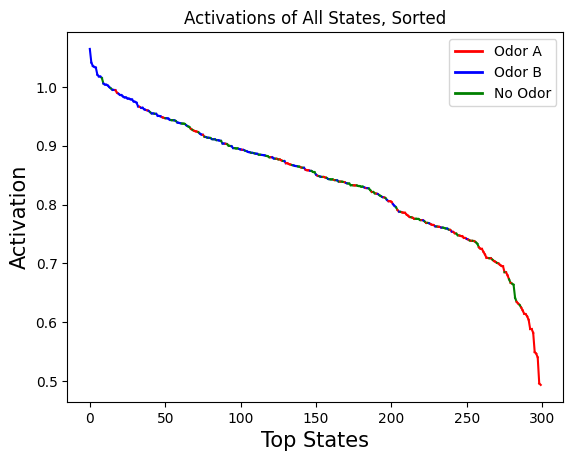

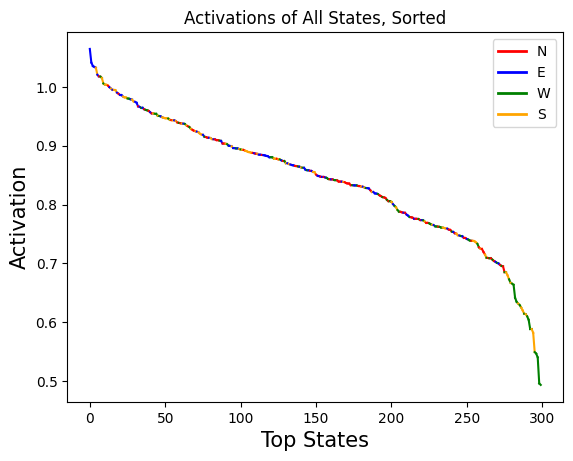

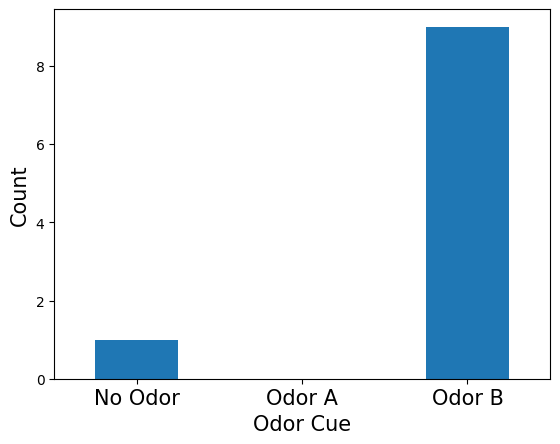

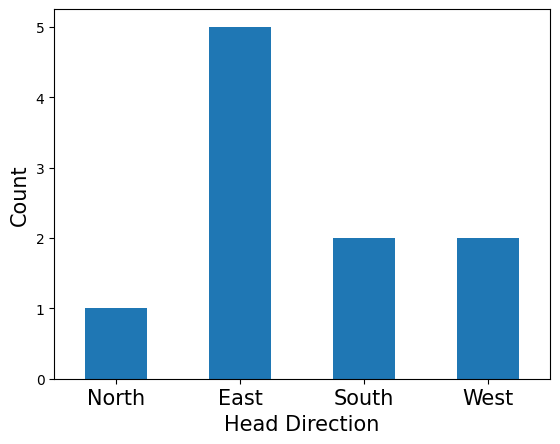

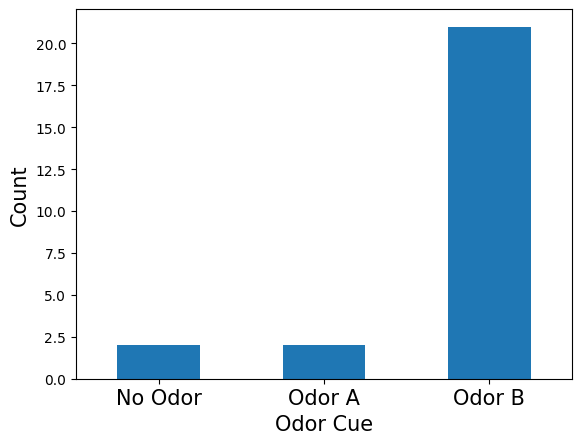

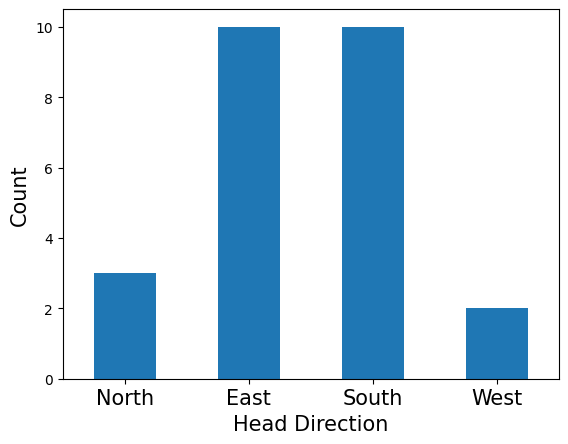

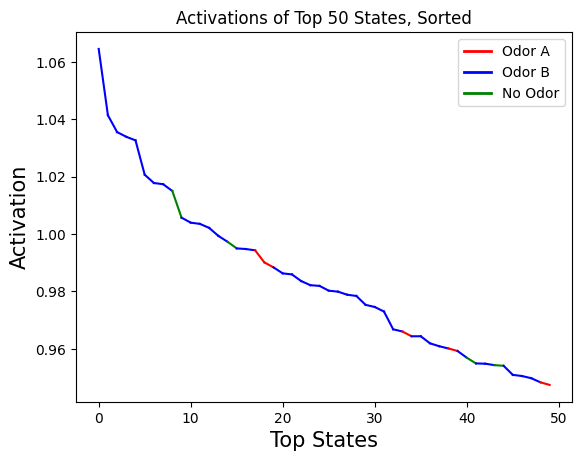

/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_79300/2902209895.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata.rename(columns={'head_dir': 'heading', 'triangle': 'UpperTriangle'}, inplace=True)
/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_79300/2902209895.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata['UpperTriangle'] = small_metadata['UpperTriangle'] == 'U'


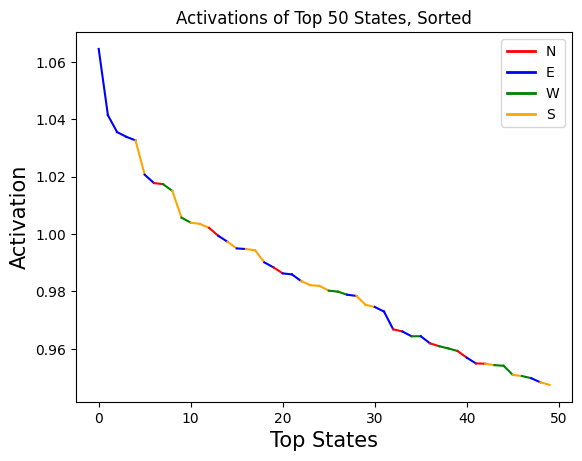

/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_79300/2902209895.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata.rename(columns={'head_dir': 'heading', 'triangle': 'UpperTriangle'}, inplace=True)
/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_79300/2902209895.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata['UpperTriangle'] = small_metadata['UpperTriangle'] == 'U'


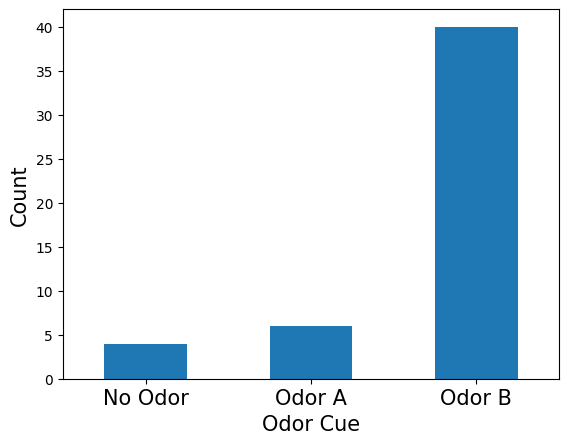

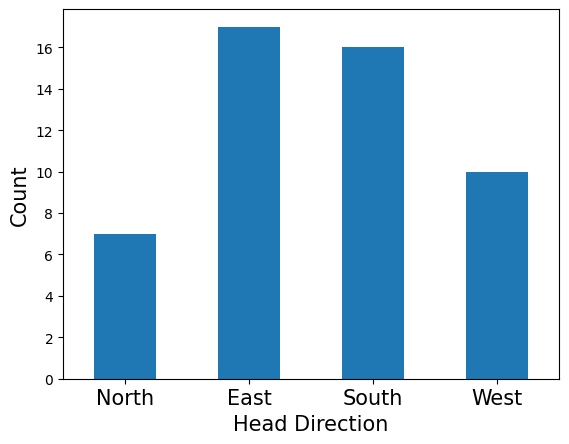

In [50]:
g=0

# Get sorted indices in descending order
sorted_indices = np.argsort(-node_activations)  # minus sign for descending sort

sorted_metadata = metadata_df.iloc[sorted_indices]
print(sorted_metadata.to_string())
sorted_activations = node_activations[sorted_indices]

odor_labels = sorted_metadata["odor"].values
dir_labels = sorted_metadata["head_dir"].values

# Map categories to colors
odor_color_map = {"Odor A": "red", "Odor B": "blue", "No Odor": "green"}
head_color_map = {"N": "red", "E": "blue", "W": "green", "S": "orange"}

for color_map in [(odor_color_map, odor_labels), (head_color_map, dir_labels)]:
    colors = [color_map[0][cat] for cat in color_map[1]]

    # Plot — color each segment between points
    for i in range(len(sorted_activations) - 1):
        plt.plot(
            [i, i+1],
            [sorted_activations[i], sorted_activations[i+1]],
            color=colors[i]
        )
    plt.ylabel("Activation", fontsize=15)
    plt.xlabel("Top States", fontsize=15)
    plt.title("Activations of All States, Sorted")

    # Create custom legend handles
    legend_handles = [
        Line2D([0], [0], color=color, lw=2, label=category)
        for category, color in color_map[0].items()
    ]
    plt.legend(handles=legend_handles)
    plt.savefig(f'figures/graph{g}.png', dpi=300, bbox_inches='tight')
    plt.show()
    g += 1

for k in [10,25,50]:
    topk_metadata = metadata_df.iloc[sorted_indices[:k]]
    topk_activations = node_activations[sorted_indices[:k]]

    odor_labels = topk_metadata["odor"].values
    dir_labels = topk_metadata["head_dir"].values

    if k == 50:
        for color_map in [(odor_color_map, odor_labels), (head_color_map, dir_labels)]:
            colors = [color_map[0][cat] for cat in color_map[1]]

            # Plot — color each segment between points
            for i in range(len(topk_activations) - 1):
                plt.plot(
                    [i, i+1],
                    [topk_activations[i], topk_activations[i+1]],
                    color=colors[i]
                )
            plt.ylabel("Activation", fontsize=15)
            plt.xlabel("Top States", fontsize=15)
            plt.title("Activations of Top 50 States, Sorted")

            # Create custom legend handles
            legend_handles = [
                Line2D([0], [0], color=color, lw=2, label=category)
                for category, color in color_map[0].items()
            ]
            plt.legend(handles=legend_handles)
            plt.savefig(f'figures/graph{g}.png', dpi=300, bbox_inches='tight')
            plt.show()
            g += 1

            small_metadata = topk_metadata[['odor', 'x', 'y', 'head_dir', 'triangle']]
            small_metadata.rename(columns={'head_dir': 'heading', 'triangle': 'UpperTriangle'}, inplace=True)
            small_metadata['UpperTriangle'] = small_metadata['UpperTriangle'] == 'U'
            topk_dict = small_metadata.to_dict(orient="records")
            with open("topk_dict.pkl", "wb") as f:
                pickle.dump(topk_dict, f)
    
    for info in ["Odor Cue", "Head Direction"]:
        if info == "Odor Cue":
            reindex = ["No Odor", "Odor A", "Odor B"]
            column = "odor"
        else:
            reindex = ["N", "E", "S", "W"]
            column = "head_dir"
            
        counts = topk_metadata[column].value_counts().reindex(reindex, fill_value=0)
        counts.plot(kind="bar")
        if info == "Head Direction":
            plt.xticks(
                ticks=range(len(counts)),
                labels=[{"N": "North", "E": "East", "W": "West", "S": "South"}[cat] for cat in counts.index],
                rotation=0
            )
        else:
            plt.xticks(
                ticks=range(len(counts)),
                rotation=0
            )
        plt.xlabel(info, fontsize=15)
        plt.ylabel("Count", fontsize=15)
        plt.xticks(fontsize=15)
        plt.savefig(f'figures/graph{g}.png', dpi=300, bbox_inches='tight')
        g += 1
        plt.show()